In [91]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
import re

In [68]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')
# loading data for Argentina
argentina_stock = pd.read_csv('data/argentina.csv',sep=',', parse_dates=['Date'], date_parser=dateparse).fillna(0)
# argentina_stock = pd.read_csv('data/argentina.csv')
argentina_stock['Vol.'] = (argentina_stock['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * argentina_stock['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
# loading data for Brazil
brazil_stock = pd.read_csv('data/brazil.csv')
brazil_stock['Vol.'] = (brazil_stock['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * brazil_stock['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
# loading data for Colombia
colombia_stock = pd.read_csv('data/colombia.csv')
colombia_stock['Vol.'] = (colombia_stock['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * colombia_stock['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
colombia_stock[['Price', 'Open','High','Low']] = colombia_stock[['Price', 'Open','High','Low']].applymap(lambda x: float(re.sub(r'[^\d.]+', '', x)))
argentina_stock

Date  Price   Open   High    Low       Vol. Change %
0   2021-03-31  85.15  86.50  88.10  85.15   564300.0   -1.10%
1   2021-03-30  86.10  85.15  86.75  84.60   141400.0    1.29%
2   2021-03-29  85.00  80.00  86.00  79.00   371220.0    3.85%
3   2021-03-26  81.85  84.00  84.60  80.70   462550.0   -2.09%
4   2021-03-25  83.60  85.20  87.30  82.10   389780.0   -3.13%
..         ...    ...    ...    ...    ...        ...      ...
295 2020-01-08  46.50  47.50  47.50  46.00  1180000.0   -2.31%
296 2020-01-07  47.60  48.35  49.00  46.90   901950.0   -1.86%
297 2020-01-06  48.50  48.40  48.70  47.00   719240.0   -0.61%
298 2020-01-03  48.80  48.25  49.45  46.50   595360.0    1.14%
299 2020-01-02  48.25  49.35  50.20  47.55   878500.0   -2.92%

[300 rows x 7 columns]

Visualize the stock’s daily closing price

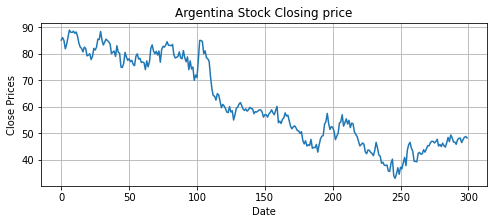

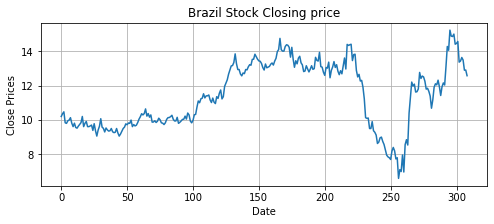

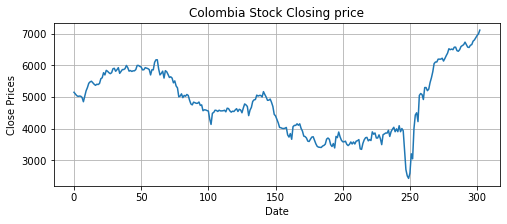

In [53]:
#plot close price
plt.figure(figsize=(8,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(argentina_stock['Price'])
plt.title('Argentina Stock Closing price')
plt.show()

plt.figure(figsize=(8,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(brazil_stock['Price'])
plt.title('Brazil Stock Closing price')
plt.show()

max = colombia_stock['Price'].min()
min = colombia_stock['Price'].min()
plt.figure(figsize=(8,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(colombia_stock['Price'])
plt.title('Colombia Stock Closing price')
plt.show()

Probability distribution

<AxesSubplot:ylabel='Density'>

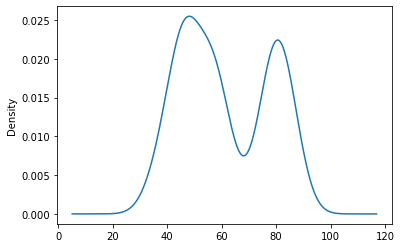

In [54]:
#Distribution of the argentina stock
df_arg = argentina_stock['Price']
df_arg.plot(kind='kde')

In [71]:
# spliting train and test data for Argentina Stock
start_date = '2021-01-01' 
end_date = '2021-03-31'
test = argentina_stock.loc[(argentina_stock['Date'] >= start_date) & (argentina_stock['Date'] <= end_date)]
train = argentina_stock[~argentina_stock.index.isin(test.index)]
# training_data = argentina_stock[['Date','Price']]
# training_data['Date'] = pd.to_datetime(training_data['Date'])
# training_data.set_index('Date', inplace=True)
train

Date  Price   Open   High    Low       Vol. Change %
60  2020-12-30  76.90  76.60  78.90  75.90   838050.0    0.39%
61  2020-12-29  76.60  74.50  78.25  73.60   499570.0    3.51%
62  2020-12-28  74.00  77.00  77.30  74.00   855030.0   -4.27%
63  2020-12-23  77.30  76.50  78.00  75.05   930050.0    3.00%
64  2020-12-22  75.05  78.50  79.45  75.00   855750.0   -2.53%
..         ...    ...    ...    ...    ...        ...      ...
295 2020-01-08  46.50  47.50  47.50  46.00  1180000.0   -2.31%
296 2020-01-07  47.60  48.35  49.00  46.90   901950.0   -1.86%
297 2020-01-06  48.50  48.40  48.70  47.00   719240.0   -0.61%
298 2020-01-03  48.80  48.25  49.45  46.50   595360.0    1.14%
299 2020-01-02  48.25  49.35  50.20  47.55   878500.0   -2.92%

[240 rows x 7 columns]

In [72]:
X_train = train[['Date','Price']]
X_train['Date'] = pd.to_datetime(X_train['Date'])
X_train.set_index('Date', inplace=True)

In [73]:
y_test = test[['Date','Price']]
y_test['Date'] = pd.to_datetime(y_test['Date'])
y_test.set_index('Date', inplace=True)

Developing ARIMA mode

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1030.896, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1031.735, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1031.803, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1029.693, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1032.387, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.284 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -513.847
Date:                Fri, 17 Feb 2023   AIC                           1029.693
Time:                        11:27:28   BIC                           1033.170
Sample:                             0   HQIC                          1031.094
                                - 240                                       

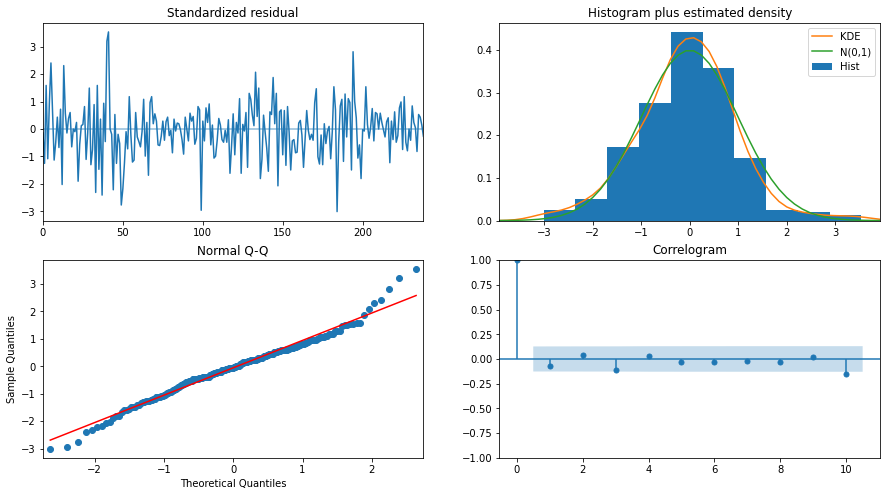

In [75]:
model_autoARIMA = auto_arima(X_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [109]:
model = auto_arima(X_train, start_p=0, start_q=0, max_p=3, max_q=3, m=1,
                   start_P=0, seasonal=False, d=None, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)

# Make predictions on the test set provided start and end lengths
# start = len(train)
# end = len(train) + len(test) - 1
# forecast = model.predict(start=start, end=end)

# Use the fitted model to make predictions on the test set
forecast, conf_int = model.predict(n_periods=7, index=y_test.index, return_conf_int=True)

# Print the predicted values and confidence intervals
print(forecast)
print(conf_int)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1030.896, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1031.735, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1031.803, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1029.693, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1032.387, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.090 seconds
240    48.25
241    48.25
242    48.25
243    48.25
244    48.25
245    48.25
246    48.25
dtype: float64
[[44.17865334 52.32134666]
 [42.49224634 54.00775366]
 [41.19822073 55.30177927]
 [40.10730668 56.39269332]
 [39.14619211 57.35380789]
 [38.27727812 58.22272188]
 [37.47822924 59.02177076]]


In [110]:
mse = mean_squared_error(y_test[:7], forecast)
mape = mean_absolute_percentage_error(y_test[:7], forecast)
print('Mean absolute error MSE is ', mse)
print('Mean absolute percentage error MAPE is ', mape)

Mean absolute error MSE is  1374.800357142857
Mean absolute percentage error MAPE is  0.4338320057284202
